<a href="https://colab.research.google.com/github/Violeta759/Tarea-de-clase-sesiones-3-y-4/blob/main/Naive_Bayes_(Sesi%C3%B3n_4)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Estudiante**: Violeta Del Burgo Sendarrubias.

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables, nos den la probabilidad o el rating de darle un préstamo a un cliente.

## Carga de Datos:

In [1]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 83.1MB/s]


##1º. Cargamos la extensión sql.

In [2]:
%load_ext sql

## 2º. Nos conectamos con la base de datos.

In [3]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

- ¿Cuántos préstamos hay por cada estado (status)?


In [4]:
%%sql
SELECT status, count(*) as total
FROM loan
GROUP BY status
ORDER BY total DESC 

 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


- Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

> Con una sentencia *CASE* vamos a poner los préstamos finalizados bien a 1 y los que no finalizaron bien a 0. 

>(Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas).

In [57]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


 > **substr(l.date,0,3)** -> coger los 3 primeros dígitos de las fechas. 

## 3. Obtenemos el DataFrame.

In [58]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [59]:
df_train.shape
#Dimensiones de train.

(234, 7)

- Para la parte de *test* lo que vamos a extraer de la Base de Datos son los préstamos que están en ejecución (`status in ("C", "D")`) con los mismos campos que en la consulta anterior.

In [60]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


In [61]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


In [62]:
df_test.shape

(448, 7)

### Ejercicio 1: Añadir la edad del cliente propietario de la cuenta del préstamo y algún campo de datos demográficos adicionales.


In [63]:
  %%sql loans_train3 << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13, A2, A3,  99 - substr(birth_number,0,3) edad, 
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, CLIENT c, DISTRICT d, DISPOSITION p
  WHERE a.district_id = d.A1 
  AND l.account_id = a.account_id 
  AND c.client_id = p.client_id
  AND p.account_id = a.account_id 
  AND l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train3


In [64]:
df_train5 = loans_train3.DataFrame()
df_train5.shape

(289, 10)

In [65]:
df_train5 = loans_train3.DataFrame()
df_train5.head()

,year,amount,duration,payments,A11,A13,A2,A3,edad,label
0,94,80952,24,3373,12541,0.43,Hl.m. Praha,Prague,54,1
1,94,80952,24,3373,12541,0.43,Hl.m. Praha,Prague,59,1
2,96,30276,12,2523,9104,2.07,Tabor,south Bohemia,60,0
3,97,30276,12,2523,9893,4.72,Frydek - Mistek,north Moravia,37,1
4,96,165960,24,6915,8427,1.54,Jindrichuv Hradec,south Bohemia,55,1


In [66]:
  %%sql loans_test3 << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13, A2, A3,  99 - substr(birth_number,0,3) edad, 
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, CLIENT c, DISTRICT d, DISPOSITION p
  WHERE a.district_id = d.A1 
  AND l.account_id = a.account_id 
  AND c.client_id = p.client_id
  AND p.account_id = a.account_id 
  AND l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test3


In [68]:
df_test5 = loans_test3.DataFrame()
df_test5.head()

,year,amount,duration,payments,A11,A13,A2,A3,edad,label
0,98,318480,60,5308,8547,3.64,Strakonice,south Bohemia,47,0
1,98,110736,48,2307,8402,3.98,Prachatice,south Bohemia,59,1
2,97,265320,36,7370,8254,3.76,Chrudim,east Bohemia,32,0
3,98,352704,48,7348,9104,2.07,Tabor,south Bohemia,49,1
4,97,162576,36,4516,9198,4.28,Liberec,north Bohemia,46,1


In [69]:
df_test5.shape

(538, 10)

## 4. División de los datos en entrenamiento y test.

> `features` es una variable de tipo lista que me almacena los nombres de las características que me sirven como **entrada**

In [70]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

Los datos los hemos dividido en:
* train (creación del modelo) : datos de préstamos ya finalizados.
* test (evaluación del modelo): datos de préstamos en ejecución.

In [71]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]

## 5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

> Más información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler).


In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# cálculo de los factores de centrado y escalado.
scaler.fit(X_train) 
# transformación.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

> **scaler.fit(X_train) **-> son medias y desviaciones que sólo haces a train. Realmente lo haces a train y con eso lo "comparas" con train y test. Si coges train y test es un error y además muy común. 

## 6. Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos.

In [73]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB
gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("El número de préstamos mal clasificados de un total de: %d, son: %d."  % (X_test.shape[0], (y_test != y_pred).sum()))
#Muestra de resultados sencilla. 

El número de préstamos mal clasificados de un total de: 448, son: 123.


Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report).

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))
#Muestra de resultados + completa. 

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



## 7. Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

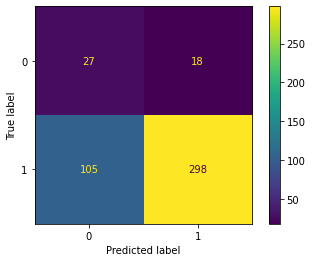

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Diagonal principal aciertos. El resto errores. El azul es lo que hemos fallado que pensaban que iban a pagar y no han pagado...(dependiendo de lo que sea 0 y 1 para nosotros y lo que hayamos definido antes). 

> Otras transformaciones: Discretización y utilización de otros clasificadores NB (algo + avanzado).

### Ejercicio 2:

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).


In [40]:
  %%sql loans_train2 << SELECT substr(l.date,0,3) year, l.amount, duration, payments, A11, A13, A2, A3, bank_to, 99 - substr(birth_number,0,3) edad,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, DISTRICT d, PERMANENT_ORDER o, CLIENT c, DISPOSITION p
  WHERE a.district_id = d.A1 
  AND l.account_id = a.account_id 
  AND o.account_id = a.account_id
  AND c.client_id = p.client_id
  AND p.account_id = a.account_id 
  AND l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train2


In [42]:
df_train2 = loans_train2.DataFrame()
df_train2.head()

,year,amount,duration,payments,A11,A13,A2,A3,bank_to,edad,label
0,94,80952,24,3373,12541,0.43,Hl.m. Praha,Prague,QR,54,1
1,94,80952,24,3373,12541,0.43,Hl.m. Praha,Prague,ST,54,1
2,94,80952,24,3373,12541,0.43,Hl.m. Praha,Prague,QR,59,1
3,94,80952,24,3373,12541,0.43,Hl.m. Praha,Prague,ST,59,1
4,96,30276,12,2523,9104,2.07,Tabor,south Bohemia,QR,60,0


In [43]:
df_train2.shape

(669, 11)

In [44]:
  %%sql loans_test2 << SELECT substr(l.date,0,3) year, l.amount, duration, payments, A11, A13, A2, A3, bank_to, 99 - substr(birth_number,0,3) edad,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a, DISTRICT d, PERMANENT_ORDER o, CLIENT c, DISPOSITION p
  WHERE a.district_id = d.A1 
  AND l.account_id = a.account_id 
  AND o.account_id = a.account_id
  AND c.client_id = p.client_id
  AND p.account_id = a.account_id 
  AND l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test2


In [45]:
df_test2 = loans_test2.DataFrame()
df_test2.head()

,year,amount,duration,payments,A11,A13,A2,A3,bank_to,edad,label
0,98,318480,60,5308,8547,3.64,Strakonice,south Bohemia,IJ,47,0
1,98,318480,60,5308,8547,3.64,Strakonice,south Bohemia,OP,47,0
2,98,318480,60,5308,8547,3.64,Strakonice,south Bohemia,QR,47,0
3,98,318480,60,5308,8547,3.64,Strakonice,south Bohemia,YZ,47,0
4,98,110736,48,2307,8402,3.98,Prachatice,south Bohemia,EF,59,1


In [46]:
df_test2.shape

(1172, 11)

In [47]:
features2 = ["year", "amount", "duration", "payments"]

In [48]:
X_train3= df_train2[features2]
y_train3 = df_train2["label"]

X_test3 = df_test2[features2]
y_test3= df_test2["label"]

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train3) 
X_train3 = scaler.transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [50]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB()
clf = gnb.fit(X_train3, y_train3)
y_pred = clf.predict(X_test3)
print("El número de préstamos mal clasificados de un total de: %d, son: %d."  % (X_test3.shape[0], (y_test3 != y_pred).sum()), )

El número de préstamos mal clasificados de un total de: 1172, son: 274.


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test3, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.18      0.71      0.28        76
           1       0.97      0.77      0.86      1096

    accuracy                           0.77      1172
   macro avg       0.58      0.74      0.57      1172
weighted avg       0.92      0.77      0.82      1172



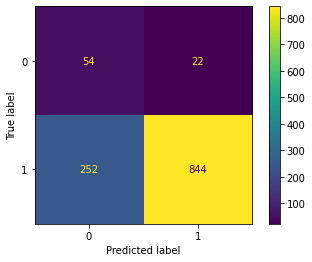

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test3, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()